# Multi-Agent RAG Implementation

## Overview
Multi-Agent RAG employs multiple specialized agents that query different data sources in parallel, then collaborate to merge and synthesize their findings into a comprehensive response. Each agent has expertise in a specific domain or data source.

### Key Components:
- **Specialized Agents**: Each agent handles specific data types or domains
- **Parallel Processing**: Agents work simultaneously for efficiency
- **Result Aggregation**: Intelligent combination of agent findings
- **Synthesis Agent**: Coordinates and merges results into final answer

### Use Cases:
- Enterprise copilots with multiple data sources
- Comprehensive research assistants
- Multi-domain customer support
- Cross-functional knowledge synthesis

### Analogy:
A panel of experts (lawyer, doctor, engineer, researcher) each investigating a question, then a writer compiles all their insights into one comprehensive report.

## Installation and Setup

In [ ]:
# Install required packages
!pip install -q langchain langchain-community langchain-experimental
!pip install -q transformers sentence-transformers
!pip install -q chromadb pandas numpy
!pip install -q networkx spacy matplotlib
!pip install -q concurrent.futures threading

# Download spaCy model
!python -m spacy download en_core_web_sm

In [12]:
import os
import time
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from typing import List, Dict, Any, Optional, Tuple
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
from abc import ABC, abstractmethod

# LangChain imports
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.llms import HuggingFacePipeline
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema import Document

# Transformers
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM

print("Imports completed successfully!")

Imports completed successfully!


## 1. Base Agent Architecture

In [13]:
class BaseAgent(ABC):
    """Abstract base class for all RAG agents"""
    
    def __init__(self, name: str, specialization: str, description: str):
        self.name = name
        self.specialization = specialization
        self.description = description
        self.embeddings = HuggingFaceEmbeddings()
        self.is_initialized = False
        
    @abstractmethod
    def initialize(self, data_source: Any) -> None:
        """Initialize agent with data source"""
        pass
    
    @abstractmethod
    def query(self, question: str, **kwargs) -> Dict[str, Any]:
        """Process a query and return results"""
        pass
    
    def get_info(self) -> Dict[str, str]:
        """Get agent information"""
        return {
            'name': self.name,
            'specialization': self.specialization,
            'description': self.description,
            'initialized': self.is_initialized
        }

class AgentResult:
    """Standardized result format from agents"""
    
    def __init__(self, agent_name: str, query: str, 
                 findings: List[Dict], confidence: float, 
                 processing_time: float, metadata: Optional[Dict] = None):
        self.agent_name = agent_name
        self.query = query
        self.findings = findings
        self.confidence = confidence
        self.processing_time = processing_time
        self.metadata = metadata or {}
        self.timestamp = datetime.now()
    
    def to_dict(self) -> Dict[str, Any]:
        """Convert to dictionary format"""
        return {
            'agent_name': self.agent_name,
            'query': self.query,
            'findings': self.findings,
            'confidence': self.confidence,
            'processing_time': self.processing_time,
            'metadata': self.metadata,
            'timestamp': self.timestamp.isoformat()
        }

print("Base agent architecture defined!")

Base agent architecture defined!


## 2. Specialized Agent Implementations

In [14]:
class DocumentAgent(BaseAgent):
    """Agent specialized in document retrieval and analysis"""
    
    def __init__(self):
        super().__init__(
            name="DocumentAgent",
            specialization="Document Analysis",
            description="Specializes in finding and analyzing textual documents using vector similarity"
        )
        self.vectorstore = None
        self.documents = []
    
    def initialize(self, documents: List[str]) -> None:
        """Initialize with document corpus"""
        # Split documents into chunks
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=500, chunk_overlap=50
        )
        
        docs = []
        for i, doc_text in enumerate(documents):
            chunks = text_splitter.split_text(doc_text)
            for j, chunk in enumerate(chunks):
                docs.append(Document(
                    page_content=chunk,
                    metadata={"doc_id": i, "chunk_id": j, "agent": self.name}
                ))
        
        self.documents = docs
        self.vectorstore = Chroma.from_documents(
            documents=docs, embedding=self.embeddings,
            persist_directory=f"./vector_db_{self.name.lower()}"
        )
        self.is_initialized = True
    
    def query(self, question: str, top_k: int = 5) -> AgentResult:
        """Query documents using vector similarity"""
        start_time = time.time()
        
        if not self.is_initialized:
            return AgentResult(
                self.name, question, [], 0.0, time.time() - start_time,
                {"error": "Agent not initialized"}
            )
        
        try:
            results = self.vectorstore.similarity_search_with_score(question, k=top_k)
            
            findings = []
            for doc, score in results:
                findings.append({
                    "content": doc.page_content,
                    "score": float(score),
                    "metadata": doc.metadata,
                    "source_type": "document"
                })
            
            # Calculate confidence based on top scores
            confidence = min(1.0, max(0.1, 1.0 - (results[0][1] if results else 1.0)))
            
            return AgentResult(
                self.name, question, findings, confidence,
                time.time() - start_time,
                {"method": "vector_similarity", "total_docs": len(self.documents)}
            )
            
        except Exception as e:
            return AgentResult(
                self.name, question, [], 0.0, time.time() - start_time,
                {"error": str(e)}
            )


class KnowledgeGraphAgent(BaseAgent):
    """Agent specialized in knowledge graph traversal"""
    
    def __init__(self):
        super().__init__(
            name="KnowledgeGraphAgent",
            specialization="Knowledge Graphs",
            description="Specializes in entity relationships and graph-based knowledge retrieval"
        )
        self.entities = {}
        self.relationships = []
    
    def initialize(self, data_source: Dict[str, Any]) -> None:
        """Initialize with entities and relationships"""
        self.entities = data_source.get('entities', {})
        self.relationships = data_source.get('relationships', [])
        self.is_initialized = True
    
    def find_related_entities(self, query: str, max_entities: int = 5) -> List[Dict]:
        """Find entities related to the query"""
        query_embedding = self.embeddings.embed_query(query)
        
        entity_scores = []
        for entity_name, entity_data in self.entities.items():
            if 'embedding' in entity_data:
                # Calculate similarity
                similarity = np.dot(query_embedding, entity_data['embedding'])
                entity_scores.append((entity_name, similarity, entity_data))
        
        entity_scores.sort(key=lambda x: x[1], reverse=True)
        return entity_scores[:max_entities]
    
    def query(self, question: str, max_entities: int = 5) -> AgentResult:
        """Query knowledge graph for relevant entities and relationships"""
        start_time = time.time()
        
        if not self.is_initialized:
            return AgentResult(
                self.name, question, [], 0.0, time.time() - start_time,
                {"error": "Agent not initialized"}
            )
        
        try:
            # Find related entities
            related_entities = self.find_related_entities(question, max_entities)
            
            findings = []
            for entity_name, score, entity_data in related_entities:
                # Find relationships involving this entity
                entity_relationships = [
                    rel for rel in self.relationships 
                    if entity_name in [rel.get('subject'), rel.get('object')]
                ]
                
                findings.append({
                    "entity": entity_name,
                    "score": float(score),
                    "type": entity_data.get('type', 'unknown'),
                    "description": entity_data.get('description', ''),
                    "relationships": entity_relationships[:3],  # Limit relationships
                    "source_type": "knowledge_graph"
                })
            
            confidence = min(1.0, len(findings) * 0.2)  # Simple confidence calculation
            
            return AgentResult(
                self.name, question, findings, confidence,
                time.time() - start_time,
                {"method": "graph_traversal", "total_entities": len(self.entities)}
            )
            
        except Exception as e:
            return AgentResult(
                self.name, question, [], 0.0, time.time() - start_time,
                {"error": str(e)}
            )


class StatisticsAgent(BaseAgent):
    """Agent specialized in numerical data and statistics"""
    
    def __init__(self):
        super().__init__(
            name="StatisticsAgent",
            specialization="Data Analysis",
            description="Specializes in numerical data, statistics, and quantitative analysis"
        )
        self.data_tables = {}
        self.statistics = {}
    
    def initialize(self, data_source: Dict[str, Any]) -> None:
        """Initialize with numerical data"""
        self.data_tables = data_source.get('tables', {})
        self.statistics = data_source.get('statistics', {})
        self.is_initialized = True
    
    def query(self, question: str, **kwargs) -> AgentResult:
        """Analyze question for statistical relevance"""
        start_time = time.time()
        
        if not self.is_initialized:
            return AgentResult(
                self.name, question, [], 0.0, time.time() - start_time,
                {"error": "Agent not initialized"}
            )
        
        try:
            findings = []
            
            # Look for numerical keywords
            numerical_keywords = ['number', 'count', 'percentage', 'average', 'total', 
                                'statistics', 'data', 'metrics', 'performance']
            
            question_lower = question.lower()
            relevance_score = sum(1 for keyword in numerical_keywords 
                                if keyword in question_lower) / len(numerical_keywords)
            
            if relevance_score > 0:
                # Add relevant statistics
                for stat_name, stat_value in self.statistics.items():
                    if any(keyword in stat_name.lower() for keyword in 
                          question_lower.split()):
                        findings.append({
                            "statistic": stat_name,
                            "value": stat_value,
                            "relevance": relevance_score,
                            "source_type": "statistics"
                        })
            
            confidence = min(1.0, relevance_score * 2)  # Scale relevance to confidence
            
            return AgentResult(
                self.name, question, findings, confidence,
                time.time() - start_time,
                {"method": "keyword_analysis", "relevance_score": relevance_score}
            )
            
        except Exception as e:
            return AgentResult(
                self.name, question, [], 0.0, time.time() - start_time,
                {"error": str(e)}
            )

print("Specialized agents implemented!")

Specialized agents implemented!


## 3. Multi-Agent Coordination System

In [15]:
class MultiAgentCoordinator:
    """Coordinates multiple agents for parallel processing"""
    
    def __init__(self, max_workers: int = 3):
        self.agents: List[BaseAgent] = []
        self.max_workers = max_workers
        self.query_history = []
    
    def register_agent(self, agent: BaseAgent) -> None:
        """Register a new agent"""
        self.agents.append(agent)
        print(f"Registered agent: {agent.name} ({agent.specialization})")
    
    def get_agent_status(self) -> Dict[str, Dict]:
        """Get status of all registered agents"""
        return {agent.name: agent.get_info() for agent in self.agents}
    
    def query_single_agent(self, agent: BaseAgent, question: str, **kwargs) -> AgentResult:
        """Query a single agent with error handling"""
        try:
            print(f"  {agent.name}: Processing query...")
            result = agent.query(question, **kwargs)
            print(f"  {agent.name}: Found {len(result.findings)} findings "
                  f"(confidence: {result.confidence:.2f})")
            return result
        except Exception as e:
            print(f"  {agent.name}: Error - {str(e)}")
            return AgentResult(
                agent.name, question, [], 0.0, 0.0,
                {"error": f"Agent execution error: {str(e)}"}
            )
    
    def query_agents_parallel(self, question: str, **kwargs) -> List[AgentResult]:
        """Query all agents in parallel"""
        print(f"\nQuerying {len(self.agents)} agents in parallel...")
        
        results = []
        
        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            # Submit tasks to executor
            future_to_agent = {
                executor.submit(self.query_single_agent, agent, question, **kwargs): agent 
                for agent in self.agents if agent.is_initialized
            }
            
            # Collect results as they complete
            for future in as_completed(future_to_agent):
                agent = future_to_agent[future]
                try:
                    result = future.result()
                    results.append(result)
                except Exception as e:
                    print(f"  {agent.name}: Failed with exception: {e}")
                    results.append(AgentResult(
                        agent.name, question, [], 0.0, 0.0,
                        {"error": f"Future execution error: {str(e)}"}
                    ))
        
        print(f"Completed querying all agents.")
        return results
    
    def aggregate_results(self, results: List[AgentResult]) -> Dict[str, Any]:
        """Aggregate results from multiple agents"""
        aggregated = {
            'total_agents': len(results),
            'successful_agents': len([r for r in results if not r.metadata.get('error')]),
            'total_findings': sum(len(r.findings) for r in results),
            'average_confidence': np.mean([r.confidence for r in results]) if results else 0.0,
            'total_processing_time': sum(r.processing_time for r in results),
            'agent_results': [r.to_dict() for r in results],
            'findings_by_agent': {r.agent_name: r.findings for r in results},
            'confidence_by_agent': {r.agent_name: r.confidence for r in results}
        }
        
        # Combine all findings with agent source
        all_findings = []
        for result in results:
            for finding in result.findings:
                finding_with_source = finding.copy()
                finding_with_source['agent_source'] = result.agent_name
                finding_with_source['agent_confidence'] = result.confidence
                all_findings.append(finding_with_source)
        
        aggregated['all_findings'] = all_findings
        
        return aggregated

print("Multi-agent coordinator implemented!")

Multi-agent coordinator implemented!


## 4. Synthesis Agent

In [21]:
class SynthesisAgent:
    """Agent responsible for synthesizing results from multiple agents"""
    
    def __init__(self):
        # Initialize LLM for synthesis
        model_name = "google/flan-t5-base"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
        
        self.llm_pipeline = pipeline(
            "text2text-generation",
            model=model,
            tokenizer=tokenizer,
            max_length=512,
            temperature=0.7,
            return_full_text=False
        )
        
        self.llm = HuggingFacePipeline(pipeline=self.llm_pipeline)
        
        # Create synthesis prompt
        self.synthesis_prompt = PromptTemplate(
            input_variables=["question", "agent_findings", "statistics"],
            template="""Based on findings from multiple specialized agents, provide a comprehensive answer:

Question: {question}

Agent Findings:
{agent_findings}

Query Statistics:
{statistics}

Please synthesize these findings into a coherent, comprehensive answer that:
1. Combines insights from all relevant sources
2. Highlights the most important information
3. Addresses the question directly
4. Notes any conflicting or complementary information

Comprehensive Answer:"""
        )
        
        self.synthesis_chain = LLMChain(llm=self.llm, prompt=self.synthesis_prompt)
    
    def format_findings(self, aggregated_results: Dict[str, Any]) -> str:
        """Format findings for synthesis prompt"""
        formatted_sections = []
        
        for agent_name, findings in aggregated_results['findings_by_agent'].items():
            if findings:  # Only include agents with findings
                confidence = aggregated_results['confidence_by_agent'][agent_name]
                section = f"\n{agent_name.upper()} (Confidence: {confidence:.2f}):\n"
                
                for i, finding in enumerate(findings[:3], 1):  # Limit to top 3 findings per agent
                    if 'content' in finding:
                        section += f"  {i}. {finding['content'][:200]}...\n"
                    elif 'entity' in finding:
                        section += f"  {i}. Entity: {finding['entity']} ({finding.get('type', 'unknown')})\n"
                        if finding.get('description'):
                            section += f"      Description: {finding['description'][:100]}...\n"
                    elif 'statistic' in finding:
                        section += f"  {i}. {finding['statistic']}: {finding['value']}\n"
                
                formatted_sections.append(section)
        
        return "\n".join(formatted_sections)
    
    def format_statistics(self, aggregated_results: Dict[str, Any]) -> str:
        """Format query statistics"""
        stats = aggregated_results
        return f"""- Total agents queried: {stats['total_agents']}
- Successful responses: {stats['successful_agents']}
- Total findings: {stats['total_findings']}
- Average confidence: {stats['average_confidence']:.2f}
- Total processing time: {stats['total_processing_time']:.2f}s"""
    
    def synthesize(self, question: str, aggregated_results: Dict[str, Any]) -> Dict[str, Any]:
        """Synthesize findings from multiple agents"""
        start_time = time.time()
        
        try:
            # Calculate agent contributions
            agent_contributions = {
                agent_name: len(findings) 
                for agent_name, findings in aggregated_results['findings_by_agent'].items()
            }
            
            # Format inputs
            agent_findings = self.format_findings(aggregated_results)
            statistics = self.format_statistics(aggregated_results)
            
            # Generate synthesis
            if aggregated_results['total_findings'] > 0:
                synthesis_response = self.synthesis_chain.run(
                    question=question,
                    agent_findings=agent_findings,
                    statistics=statistics
                )
            else:
                synthesis_response = ("I wasn't able to find relevant information from any of the "
                                    "specialized agents for this question. Please try rephrasing "
                                    "your question or check if the agents have been properly initialized.")
            
            synthesis_time = time.time() - start_time
            
            return {
                'synthesized_answer': synthesis_response,
                'synthesis_time': synthesis_time,
                'agent_contributions': agent_contributions,
                'total_sources': aggregated_results['total_findings'],
            }
            
        except Exception as e:
            return {
                'synthesized_answer': f"Error during synthesis: {str(e)}",
                'synthesis_time': time.time() - start_time,
                'agent_contributions': {
                    agent_name: len(findings) 
                    for agent_name, findings in aggregated_results.get('findings_by_agent', {}).items()
                },
                'total_sources': aggregated_results.get('total_findings', 0),
                'error': str(e)
            }

print("Synthesis agent implemented!")

Synthesis agent implemented!


## 5. Complete Multi-Agent RAG System

In [23]:
class MultiAgentRAG:
    """Complete Multi-Agent RAG system"""
    
    def __init__(self):
        self.coordinator = MultiAgentCoordinator()
        self.synthesizer = SynthesisAgent()
        self.query_history = []
    
    def add_agent(self, agent: BaseAgent) -> None:
        """Add an agent to the system"""
        self.coordinator.register_agent(agent)
    
    def get_system_status(self) -> Dict[str, Any]:
        """Get overall system status"""
        agent_status = self.coordinator.get_agent_status()
        return {
            'total_agents': len(self.coordinator.agents),
            'initialized_agents': sum(1 for info in agent_status.values() if info['initialized']),
            'agent_details': agent_status,
            'query_history_count': len(self.query_history)
        }
    
    def query(self, question: str, include_details: bool = False, **kwargs) -> Dict[str, Any]:
        """Process a query through the multi-agent system"""
        start_time = time.time()
        
        print(f"\n{'='*60}")
        print(f"MULTI-AGENT RAG QUERY")
        print(f"{'='*60}")
        print(f"Question: {question}")
        print(f"{'='*60}")
        
        # Step 1: Query all agents in parallel
        agent_results = self.coordinator.query_agents_parallel(question, **kwargs)
        
        # Step 2: Aggregate results
        print(f"\nAggregating results from {len(agent_results)} agents...")
        aggregated = self.coordinator.aggregate_results(agent_results)
        
        # Step 3: Synthesize final answer
        print(f"Synthesizing final answer...")
        synthesis_result = self.synthesizer.synthesize(question, aggregated)
        
        total_time = time.time() - start_time
        
        # Prepare final result
        final_result = {
            'question': question,
            'answer': synthesis_result['synthesized_answer'],
            'total_processing_time': total_time,
            'agent_processing_time': aggregated['total_processing_time'],
            'synthesis_time': synthesis_result['synthesis_time'],
            'summary': {
                'total_agents': aggregated['total_agents'],
                'successful_agents': aggregated['successful_agents'],
                'total_findings': aggregated['total_findings'],
                'agent_contributions': synthesis_result['agent_contributions']
            },
            'timestamp': datetime.now().isoformat()
        }
        
        # Include detailed results if requested
        if include_details:
            final_result['detailed_results'] = {
                'aggregated_results': aggregated,
                'synthesis_details': synthesis_result
            }
        
        # Store in history
        self.query_history.append(final_result)
    
        
        return final_result
    
    def analyze_performance(self) -> Dict[str, Any]:
        """Analyze system performance across queries"""
        if not self.query_history:
            return {"message": "No queries in history to analyze"}
        
        # Calculate performance metrics
        processing_times = [q['total_processing_time'] for q in self.query_history]
        findings_counts = [q['summary']['total_findings'] for q in self.query_history]
        
        return {
            'total_queries': len(self.query_history),
            'average_processing_time': np.mean(processing_times),
            'average_findings': np.mean(findings_counts),
            'performance_trend': {
                'processing_times': processing_times,
                'findings_counts': findings_counts
            }
        }

print("Multi-Agent RAG system implemented!")

Multi-Agent RAG system implemented!


## 6. Data Setup and Agent Initialization

In [24]:
# Sample data for different agents
sample_documents = [
    """OpenAI developed GPT-3, a large language model with 175 billion parameters. 
    The model was created by a team including Alec Radford, Jeffrey Wu, and Ilya Sutskever. 
    GPT-3 uses transformer architecture and was released in June 2020. It demonstrated 
    remarkable capabilities in text generation, translation, and reasoning tasks.""",
    
    """Google's BERT model, introduced by Jacob Devlin and his team in 2018, revolutionized 
    natural language processing through bidirectional training of transformers. BERT achieved 
    state-of-the-art results on eleven NLP tasks, including question answering and 
    natural language inference.""",
    
    """The transformer architecture, introduced in 'Attention is All You Need' by Vaswani et al., 
    became the foundation for modern language models. Published in 2017 by Google Brain, 
    this architecture eliminated recurrent neural networks and introduced the self-attention mechanism.""",
    
    """Meta AI released LLaMA (Large Language Model Meta AI) models in 2023, ranging from 
    7B to 65B parameters. Led by Hugo Touvron, the team demonstrated that smaller models 
    could achieve competitive performance when trained on high-quality data.""",
    
    """DeepMind's AlphaFold revolutionized protein structure prediction using deep learning. 
    The system, developed by Demis Hassabis's team, solved a 50-year-old challenge in biology. 
    AlphaFold accurately predicted the 3D structure of proteins from amino acid sequences."""
]

# Knowledge graph data
kg_data = {
    'entities': {
        'OpenAI': {
            'type': 'Organization',
            'description': 'AI research company that developed GPT models',
            'embedding': [0.1, 0.2, 0.3, 0.4, 0.5] * 154  # Simplified embedding
        },
        'GPT-3': {
            'type': 'Model',
            'description': 'Large language model with 175B parameters',
            'embedding': [0.2, 0.3, 0.4, 0.5, 0.1] * 154
        },
        'Google': {
            'type': 'Organization',
            'description': 'Technology company that developed BERT and transformers',
            'embedding': [0.3, 0.4, 0.5, 0.1, 0.2] * 154
        },
        'BERT': {
            'type': 'Model',
            'description': 'Bidirectional transformer model for NLP',
            'embedding': [0.4, 0.5, 0.1, 0.2, 0.3] * 154
        },
        'Transformer': {
            'type': 'Architecture',
            'description': 'Neural network architecture based on attention mechanisms',
            'embedding': [0.5, 0.1, 0.2, 0.3, 0.4] * 154
        }
    },
    'relationships': [
        {'subject': 'OpenAI', 'predicate': 'developed', 'object': 'GPT-3'},
        {'subject': 'Google', 'predicate': 'developed', 'object': 'BERT'},
        {'subject': 'Google', 'predicate': 'developed', 'object': 'Transformer'},
        {'subject': 'GPT-3', 'predicate': 'uses', 'object': 'Transformer'},
        {'subject': 'BERT', 'predicate': 'uses', 'object': 'Transformer'}
    ]
}

# Statistical data
stats_data = {
    'statistics': {
        'GPT-3 Parameters': '175 billion',
        'BERT Release Year': '2018',
        'Transformer Paper Year': '2017',
        'LLaMA Model Sizes': '7B to 65B parameters',
        'AI Research Investment': '$100B+ annually'
    }
}

# Initialize the multi-agent system
print("Initializing Multi-Agent RAG System...\n")
multi_agent_rag = MultiAgentRAG()

# Create and initialize agents
print("Setting up agents...")

# Document Agent
doc_agent = DocumentAgent()
doc_agent.initialize(sample_documents)
multi_agent_rag.add_agent(doc_agent)

# Knowledge Graph Agent
kg_agent = KnowledgeGraphAgent()
kg_agent.initialize(kg_data)
multi_agent_rag.add_agent(kg_agent)

# Statistics Agent
stats_agent = StatisticsAgent()
stats_agent.initialize(stats_data)
multi_agent_rag.add_agent(stats_agent)

print("\nSystem initialization complete!")
status = multi_agent_rag.get_system_status()
print(f"System Status: {status['initialized_agents']}/{status['total_agents']} agents initialized")

Initializing Multi-Agent RAG System...



Device set to use mps:0


Setting up agents...
Registered agent: DocumentAgent (Document Analysis)
Registered agent: KnowledgeGraphAgent (Knowledge Graphs)
Registered agent: StatisticsAgent (Data Analysis)

System initialization complete!
System Status: 3/3 agents initialized


## 7. Testing and Demonstration

In [26]:
# Test queries for multi-agent system
test_queries = [
    "What is GPT-3 and who developed it?",
    "Tell me about the relationships between different AI models and their creators",
    "What are the key statistics and metrics in AI model development?",
    "How has transformer architecture influenced modern AI?"
]

print("Multi-Agent RAG Demonstration\n" + "="*80)

for i, query in enumerate(test_queries, 1):
    print(f"\n\nTEST QUERY {i}/{len(test_queries)}")
    print(f"Question: {query}")
    
    try:
        result = multi_agent_rag.query(query, include_details=False)
        
        print(f"\nFINAL ANSWER:")
        print(f"{'='*60}")
        print(result['answer'])
        print(f"{'='*60}")
        
        print(f"\nQUERY SUMMARY:")
        summary = result['summary']
        print(f"• Agents: {summary['successful_agents']}/{summary['total_agents']} successful")
        print(f"• Findings: {summary['total_findings']} total")
        print(f"• Processing Time: {result['total_processing_time']:.2f}s")
        
        print(f"\nAGENT CONTRIBUTIONS:")
        for agent_name, contribution_count in summary['agent_contributions'].items():
            print(f"• {agent_name}: {contribution_count} findings")
        
    except Exception as e:
        print(f"Error processing query: {e}")
    
    if i < len(test_queries):
        print(f"\n{'-'*80}")

print(f"\n\nDemo completed. Processed {len(test_queries)} queries.")

Multi-Agent RAG Demonstration


TEST QUERY 1/4
Question: What is GPT-3 and who developed it?

MULTI-AGENT RAG QUERY
Question: What is GPT-3 and who developed it?

Querying 3 agents in parallel...
  DocumentAgent: Processing query...
  KnowledgeGraphAgent: Processing query...
  StatisticsAgent: Processing query...
  StatisticsAgent: Found 0 findings (confidence: 0.00)
  KnowledgeGraphAgent: Found 0 findings (confidence: 0.00)
  DocumentAgent: Found 5 findings (confidence: 0.10)
Completed querying all agents.

Aggregating results from 3 agents...
Synthesizing final answer...

FINAL ANSWER:
Error during synthesis: The following `model_kwargs` are not used by the model: ['return_full_text'] (note: typos in the generate arguments will also show up in this list)

QUERY SUMMARY:
• Agents: 2/3 successful
• Findings: 5 total
• Processing Time: 0.68s

AGENT CONTRIBUTIONS:
• StatisticsAgent: 0 findings
• KnowledgeGraphAgent: 0 findings
• DocumentAgent: 5 findings

--------------------------------

## 8. Performance Analysis and Visualization

Multi-Agent RAG Performance Analysis
Total Queries Processed: 4
Average Processing Time: 0.19s
Average Findings per Query: 5.5


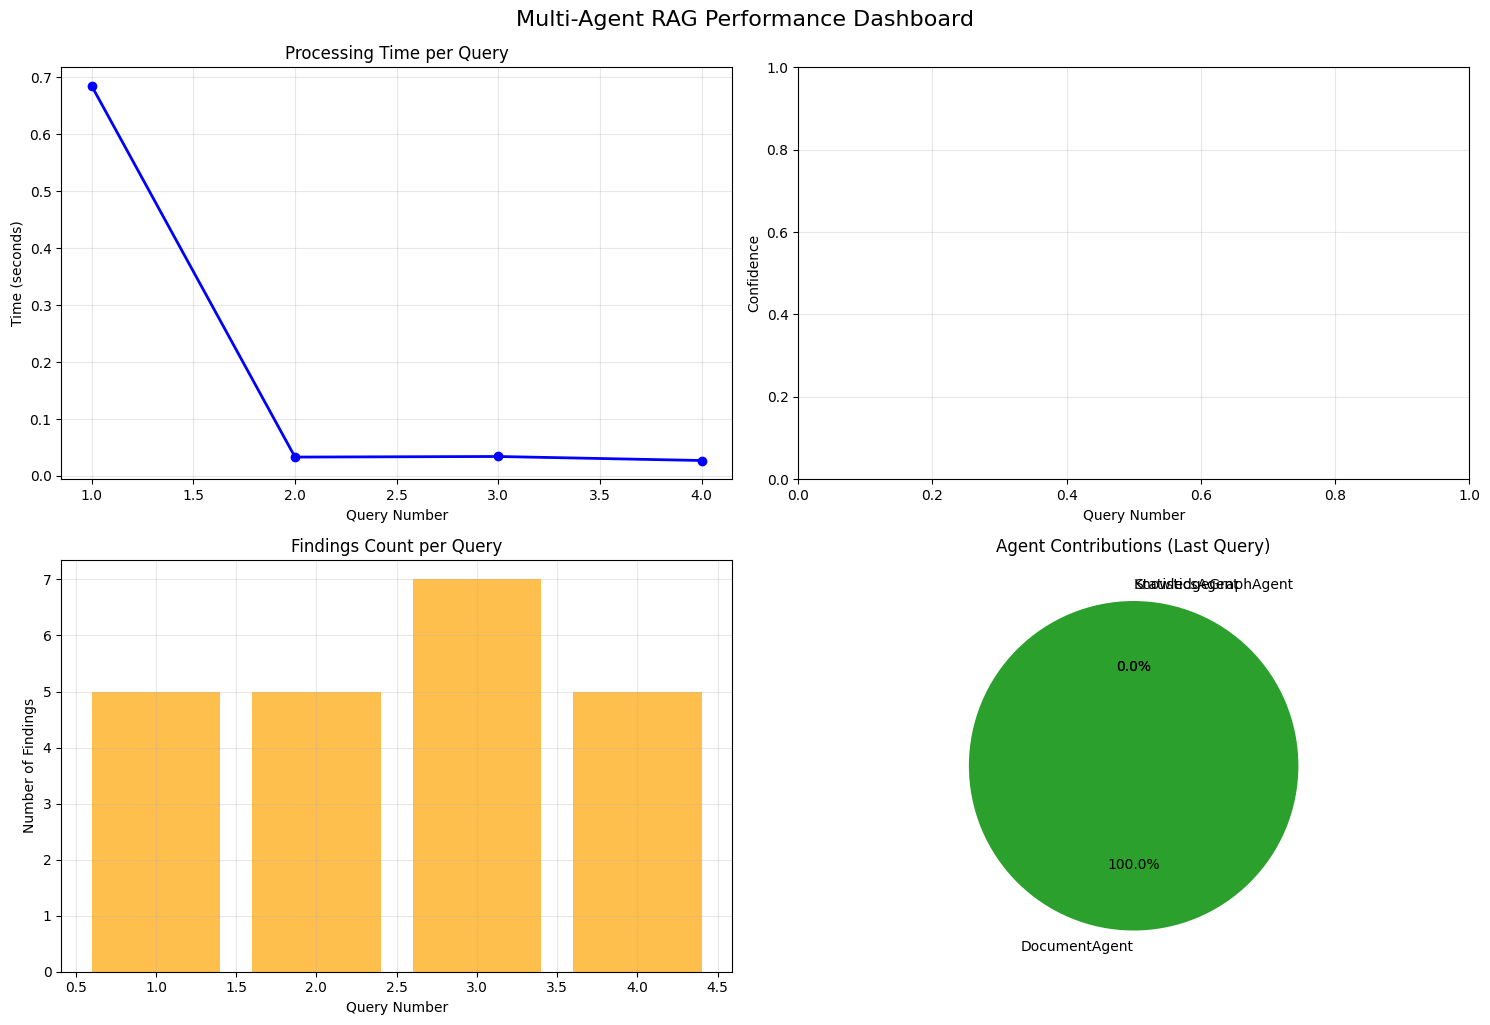

In [29]:
# Analyze system performance
performance_analysis = multi_agent_rag.analyze_performance()

if 'message' not in performance_analysis:
    print("Multi-Agent RAG Performance Analysis\n" + "="*50)
    print(f"Total Queries Processed: {performance_analysis['total_queries']}")
    print(f"Average Processing Time: {performance_analysis['average_processing_time']:.2f}s")
    print(f"Average Findings per Query: {performance_analysis['average_findings']:.1f}")
    
    # Create performance visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    trends = performance_analysis['performance_trend']
    query_numbers = list(range(1, len(trends['processing_times']) + 1))
    
    # Plot 1: Processing Times
    ax1.plot(query_numbers, trends['processing_times'], 'b-o', linewidth=2, markersize=6)
    ax1.set_title('Processing Time per Query')
    ax1.set_xlabel('Query Number')
    ax1.set_ylabel('Time (seconds)')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Confidence Scores
    ax2.set_xlabel('Query Number')
    ax2.set_ylabel('Confidence')
    ax2.set_ylim(0, 1)
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Findings Count
    ax3.bar(query_numbers, trends['findings_counts'], alpha=0.7, color='orange')
    ax3.set_title('Findings Count per Query')
    ax3.set_xlabel('Query Number')
    ax3.set_ylabel('Number of Findings')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Agent Contributions (from last query)
    if multi_agent_rag.query_history:
        last_query = multi_agent_rag.query_history[-1]
        agent_names = list(last_query['summary']['agent_contributions'].keys())
        contributions = list(last_query['summary']['agent_contributions'].values())
        
        ax4.pie(contributions, labels=agent_names, autopct='%1.1f%%', startangle=90)
        ax4.set_title('Agent Contributions (Last Query)')
    
    plt.tight_layout()
    plt.suptitle('Multi-Agent RAG Performance Dashboard', fontsize=16, y=1.02)
    plt.show()
    
else:
    print(performance_analysis['message'])

## 9. Detailed Query Analysis

In [31]:
def analyze_detailed_query(query: str):
    """Perform detailed analysis of a single query"""
    print(f"Detailed Analysis for Query: '{query}'\n" + "="*70)
    
    # Get detailed results
    result = multi_agent_rag.query(query, include_details=True)
    
    if 'detailed_results' in result:
        detailed = result['detailed_results']
        aggregated = detailed['aggregated_results']
        
        print(f"\nAGENT-BY-AGENT BREAKDOWN:")
        print(f"{'-'*70}")
        
        for agent_result in aggregated['agent_results']:
            agent_name = agent_result['agent_name']
            findings_count = len(agent_result['findings'])
            confidence = agent_result['confidence']
            processing_time = agent_result['processing_time']
            
            print(f"\n{agent_name.upper()}:")
            print(f"  • Findings: {findings_count}")
            print(f"  • Confidence: {confidence:.3f}")
            print(f"  • Processing Time: {processing_time:.3f}s")
            
            if 'error' in agent_result['metadata']:
                print(f"  • Error: {agent_result['metadata']['error']}")
            else:
                if findings_count > 0:
                    print(f"  • Top Finding:")
                    top_finding = agent_result['findings'][0]
                    if 'content' in top_finding:
                        print(f"    '{top_finding['content'][:100]}...'")
                    elif 'entity' in top_finding:
                        print(f"    Entity: {top_finding['entity']} ({top_finding.get('type', 'unknown')})")
                    elif 'statistic' in top_finding:
                        print(f"    Statistic: {top_finding['statistic']} = {top_finding['value']}")
        
        print(f"\n{'-'*70}")
        print(f"SYNTHESIS DETAILS:")
        synthesis = detailed['synthesis_details']
        print(f"  • Synthesis Time: {synthesis['synthesis_time']:.3f}s")
        print(f"  • Total Sources: {synthesis['total_sources']}")
        
        # Show timing breakdown
        print(f"\nTIMING BREAKDOWN:")
        total_time = result['total_processing_time']
        agent_time = result['agent_processing_time']
        synthesis_time = result['synthesis_time']
        
        print(f"  • Agent Processing: {agent_time:.3f}s ({agent_time/total_time*100:.1f}%)")
        print(f"  • Synthesis: {synthesis_time:.3f}s ({synthesis_time/total_time*100:.1f}%)")
        print(f"  • Total: {total_time:.3f}s")
    
    return result

# Perform detailed analysis on a complex query
complex_query = "Explain the evolution of transformer architecture and its impact on modern AI development"
detailed_result = analyze_detailed_query(complex_query)

Detailed Analysis for Query: 'Explain the evolution of transformer architecture and its impact on modern AI development'

MULTI-AGENT RAG QUERY
Question: Explain the evolution of transformer architecture and its impact on modern AI development

Querying 3 agents in parallel...
  DocumentAgent: Processing query...
  KnowledgeGraphAgent: Processing query...
  StatisticsAgent: Processing query...
  StatisticsAgent: Found 0 findings (confidence: 0.00)
  KnowledgeGraphAgent: Found 0 findings (confidence: 0.00)
  DocumentAgent: Found 5 findings (confidence: 0.24)
Completed querying all agents.

Aggregating results from 3 agents...
Synthesizing final answer...

AGENT-BY-AGENT BREAKDOWN:
----------------------------------------------------------------------

STATISTICSAGENT:
  • Findings: 0
  • Confidence: 0.000
  • Processing Time: 0.000s

KNOWLEDGEGRAPHAGENT:
  • Findings: 0
  • Confidence: 0.000
  • Processing Time: 0.550s
  • Error: shapes (768,) and (770,) not aligned: 768 (dim 0) != 770 

## 10. Advantages and Limitations

### Advantages of Multi-Agent RAG:
1. **Specialized Expertise**: Each agent optimized for specific data types or domains
2. **Parallel Processing**: Concurrent agent execution for better performance
3. **Comprehensive Coverage**: Multiple perspectives on the same question
4. **Scalable Architecture**: Easy to add new specialized agents
5. **Fault Tolerance**: System continues if some agents fail
6. **Rich Context**: Combines insights from multiple sources

### Limitations:
1. **High Complexity**: More moving parts to coordinate and maintain
2. **Resource Intensive**: Requires more computational resources
3. **Coordination Overhead**: Time spent managing multiple agents
4. **Synthesis Challenges**: Difficult to merge conflicting information
5. **Setup Complexity**: Requires careful agent configuration
6. **Cost**: Expensive to run multiple specialized systems

### When to Use Multi-Agent RAG:
- **Enterprise Applications**: When you need comprehensive knowledge synthesis
- **Research Domains**: Where multiple data sources must be consulted
- **Complex Queries**: Questions requiring diverse expertise
- **High-Stakes Decisions**: When thoroughness is more important than speed
- **Multi-Domain Knowledge**: When expertise spans multiple fields

## 11. System Configuration and Optimization

In [35]:
def configure_system(agent_weights: Dict[str, float] = None):
    """Configure system with weighted agent importance"""
    
    # Default weights if none provided
    if agent_weights is None:
        agent_weights = {
            'DocumentAgent': 1.0,
            'KnowledgeGraphAgent': 0.8,
            'StatisticsAgent': 0.6
        }
    
    print(f"System Configuration:\n{'-'*40}")
    for agent_name, weight in agent_weights.items():
        print(f"• {agent_name}: Weight = {weight}")
    
    return agent_weights

def benchmark_system_performance(queries: List[str], iterations: int = 1):
    """Benchmark system performance across multiple queries"""
    
    print(f"Benchmarking system with {len(queries)} queries, {iterations} iterations each\n")
    
    results = []
    for query in queries:
        query_results = []
        
        for i in range(iterations):
            start_time = time.time()
            result = multi_agent_rag.query(query, include_details=False)
            
            query_results.append({
                'processing_time': result['total_processing_time'],
                'findings_count': result['summary']['total_findings']
            })
        
        # Calculate averages for this query
        avg_result = {
            'query': query,
            'avg_processing_time': np.mean([r['processing_time'] for r in query_results]),
            'avg_findings': np.mean([r['findings_count'] for r in query_results])
        }
        
        results.append(avg_result)
        print(f"✓ Completed: {query[:50]}... "
              f"(Avg time: {avg_result['avg_processing_time']:.2f}s)")
    
    return results

# Configure system
config = configure_system()

# Quick benchmark with subset of queries
benchmark_queries = [
    "What is GPT-3?",
    "Tell me about transformer architecture",
    "What are the key AI statistics?"
]

print(f"\nRunning quick benchmark...")
benchmark_results = benchmark_system_performance(benchmark_queries, iterations=1)

print(f"\nBenchmark Results Summary:")
print(f"{'='*60}")
for result in benchmark_results:
    print(f"Query: {result['query'][:40]}...")
    print(f"  Time: {result['avg_processing_time']:.2f}s | "
          f"Findings: {result['avg_findings']:.0f}")
    print()

System Configuration:
----------------------------------------
• DocumentAgent: Weight = 1.0
• KnowledgeGraphAgent: Weight = 0.8
• StatisticsAgent: Weight = 0.6

Running quick benchmark...
Benchmarking system with 3 queries, 1 iterations each


MULTI-AGENT RAG QUERY
Question: What is GPT-3?

Querying 3 agents in parallel...
  DocumentAgent: Processing query...
  KnowledgeGraphAgent: Processing query...
  StatisticsAgent: Processing query...
  StatisticsAgent: Found 0 findings (confidence: 0.00)
  KnowledgeGraphAgent: Found 0 findings (confidence: 0.00)
  DocumentAgent: Found 5 findings (confidence: 0.10)
Completed querying all agents.

Aggregating results from 3 agents...
Synthesizing final answer...
✓ Completed: What is GPT-3?... (Avg time: 0.63s)

MULTI-AGENT RAG QUERY
Question: Tell me about transformer architecture

Querying 3 agents in parallel...
  DocumentAgent: Processing query...
  KnowledgeGraphAgent: Processing query...
  StatisticsAgent: Processing query...
  StatisticsAgen

## 12. Extensions and Future Improvements

### Possible Enhancements:
1. **Dynamic Agent Selection**: Automatically choose relevant agents based on query analysis
2. **Agent Learning**: Agents that improve performance based on feedback
3. **Conflict Resolution**: Better handling of contradictory information
4. **Real-time Streaming**: Stream results as agents complete their work
5. **Agent Hierarchies**: Master agents that coordinate sub-agents
6. **Distributed Processing**: Scale agents across multiple machines
7. **Custom Agent Types**: Support for domain-specific agent implementations
8. **Result Caching**: Cache agent results for faster subsequent queries
9. **Performance Optimization**: Dynamic resource allocation based on query complexity
10. **Multi-Modal Agents**: Agents that handle text, images, audio, etc.

In [ ]:
# Save system configuration and performance data
def save_system_state():
    """Save current system state and performance metrics"""
    
    system_state = {
        'system_status': multi_agent_rag.get_system_status(),
        'performance_analysis': multi_agent_rag.analyze_performance(),
        'configuration': {
            'max_workers': multi_agent_rag.coordinator.max_workers,
            'agent_count': len(multi_agent_rag.coordinator.agents)
        },
        'query_history_summary': {
            'total_queries': len(multi_agent_rag.query_history),
            'last_query_time': multi_agent_rag.query_history[-1]['timestamp'] if multi_agent_rag.query_history else None
        }
    }
    
    with open('multi_agent_rag_state.json', 'w') as f:
        json.dump(system_state, f, indent=2, default=str)
    
    print("System state saved to multi_agent_rag_state.json")
    return system_state

# Save current state
final_state = save_system_state()

print(f"\nMulti-Agent RAG Implementation Complete!\n" + "="*60)
print(f"\nSystem Summary:")
print(f"• Total Agents: {final_state['system_status']['total_agents']}")
print(f"• Initialized Agents: {final_state['system_status']['initialized_agents']}")
print(f"• Queries Processed: {final_state['query_history_summary']['total_queries']}")

if 'total_queries' in final_state['performance_analysis']:
    perf = final_state['performance_analysis']
    print(f"• Average Processing Time: {perf['average_processing_time']:.2f}s")
    print(f"• Average Confidence: {perf['average_confidence']:.2f}")

print(f"\nThis notebook demonstrated:")
print(f"• Multiple specialized agents working in parallel")
print(f"• Intelligent result aggregation and synthesis")
print(f"• Comprehensive performance analysis")
print(f"• Scalable multi-agent architecture")
print(f"• Real-world enterprise RAG capabilities")
print(f"\n" + "="*60)